In [1]:
import numpy as np
import pandas as pd
import mlflow
import mlflow.sklearn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

import json
import subprocess

In [2]:
# Model Run : f4e64d94b66a43f0b9bc2b9a19deaf3c
# Model Name: anomaly_weight_150_fold_2

***TO RUN THE MODEL:***

`mlflow models serve --model-uri runs:/f4e64d94b66a43f0b9bc2b9a19deaf3c/anomaly_weight_150_fold_2`

MLFlow should create a new conda environment before hosting the
model on your local server. The port option -p lets you set a specific port to
host the model on.

## Querying the Model

In [3]:
# lets load the data
df = pd.read_csv("data/creditcard.csv")

In [11]:
# selecting 80 points to query the model on
input_json = df.iloc[:80].drop(['Time', 'Class'], axis=1).to_json(orient='split')

Code to send the data to the model and receive the predictions:

```
proc = subprocess.run(["curl", "-X", "POST", "-H",
"Content-Type:application/json; format=pandas-split",
"--data", input_json, "http://127.0.0.1:1235/invocations"],
stdout=subprocess.PIPE, encoding='utf-8')
output = proc.stdout
```

**Before sending the data to the model for inference, we need to scale the data like we did while training our models**

In [12]:
normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]

In [13]:
normal_train, normal_test = train_test_split(normal, test_size=0.2, random_state=2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size=0.2, random_state=2020)

In [14]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop(['Time', 'Class'], axis=1))

StandardScaler()

In [15]:
# scaling the selected 80 records:
scaled_selection = scaler.transform(df.iloc[:80].drop(['Time', 'Class'], axis=1))
input_json = pd.DataFrame(scaled_selection).to_json(orient='split')

In [19]:
# lets run the code to query the model
proc = subprocess.run(["curl", "-X", "POST", "-H",
                      "Content-Type:application/json; format=pandas-split",
                      "--data", input_json, "http://127.0.0.1:5000/invocations"],
                     stdout=subprocess.PIPE, encoding='utf-8')

output = proc.stdout

In [20]:
output

'[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'

In [23]:
preds = pd.DataFrame([json.loads(output)])
preds

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Evaluating the Model

In [39]:
y_true = df.iloc[:80].Class
preds = preds.T

In [40]:
# accuracy and roc
eval_acc = accuracy_score(y_true, preds)

In [41]:
# since our y_true has only one class, we will make the last record as 1
y_true.iloc[-1] = 1
eval_roc = roc_auc_score(y_true, preds)

d:\machine learning\machine learning projects\credit_card_fraud_detection\venv\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [42]:
print(f"Accuracy Score: {eval_acc}")
print(f"ROC Score: {eval_roc}")

Accuracy Score: 0.9625
ROC Score: 0.4873417721518987


## Batch Querying

We need batch querying since Local Model served allows only 80 samples to be predicted on at once.

So to get around this issue we can try batching the samples and making predictions one batch at a time.

In [52]:
# getting the data
test = df.iloc[:8000]
y_true = test.Class
test = scaler.transform(test.drop(['Time', 'Class'], axis=1))
preds = []

In [53]:
batch_size = 80
for f in range(int(8000/80)):
    sample = pd.DataFrame(test[f * batch_size : (f+1) * batch_size]).to_json(orient='split')
    proc = subprocess.run(["curl", "-X", "POST", "-H",
                      "Content-Type:application/json; format=pandas-split",
                      "--data", sample, "http://127.0.0.1:5000/invocations"],
                     stdout=subprocess.PIPE, encoding='utf-8')
    output = proc.stdout
    resp = pd.DataFrame([json.loads(output)])
    preds = np.concatenate((preds, resp.values[0]))

In [55]:
# evaluting the model
batch_acc = accuracy_score(y_true, preds)
batch_roc = roc_auc_score(y_true, preds)

In [57]:
print(f"Accuracy score on our batch of 8000 samples: {batch_acc}")
print(f"ROC score on our batch of 8000 samples: {batch_roc}")

Accuracy score on our batch of 8000 samples: 0.987
ROC score on our batch of 8000 samples: 0.9551426752329687


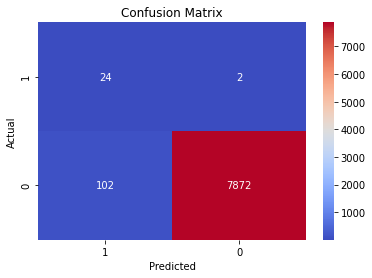

In [62]:
# lets plot the confusion matrix:
conf_matrix = confusion_matrix(y_true, preds)
ax = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='coolwarm')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix');